# Guide To Ensembling

In this guide, you'll learn how to create an ensemble model. Ensembles are a common way to train a larger model successfully. In this guide, you'll run an experiment to determine if ensembling is useful for your problem of classifying CIFAR10. You will generate three scenarios to compare:

1) As a first baseline, a model trained without Masterful. 
2) As a second baseline, the same model architecture trained by Masterful including Masterful's regularization techniques. This baseline allows you to to ablate the effects of regularization from ensembling. 
3) An ensemble model created by Masterful, including Masterful's regularization techniques. The null hypothesis you seek to reject is that the Masterful trained ensemble does not deliver better accuracy than the two baselines. 

For more information on the theory of ensembles, see the concepts doc. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/masterfulai/masterful-docs/blob/main/notebooks/guide_ensembling.ipynb)
[![download button](https://www.tensorflow.org/images/download_logo_32px.png)](https://masterful-public.s3.us-west-1.amazonaws.com/933013963/latest/guide_ensembling.ipynb) Download this Notebook

First, import the necessary libraries.

In [1]:
from dataclasses import asdict
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

MASTERFUL_ACCOUNT_ID="<INSERT HERE>"
MASTERFUL_AUTHORIZATION_KEY="<INSERT HERE>"
import masterful
masterful = masterful.register(account_id=MASTERFUL_ACCOUNT_ID, authorization_key=MASTERFUL_AUTHORIZATION_KEY)



Prepare your dataset. You'll use the MNIST dataset for this guide. 

In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data into the range [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape the data as single channel images.
x_train = tf.reshape(x_train, (-1, 28, 28, 1))
x_test = tf.reshape(x_test, (-1, 28, 28, 1))

# Convert labels to one-hot. 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

labeled_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

Now, build a simple model architecture. 

In [3]:
def get_model():
    model = tf.keras.Sequential(
      [
          tf.keras.Input(shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(5, (3, 3), strides=(2, 2), padding="same"),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(num_classes),
      ]
    )
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 5)         50        
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 980)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                9810      
Total params: 9,860
Trainable params: 9,860
Non-trainable params: 0
_________________________________________________________________


To implement scenario 1, train the model without using Masterful. This will train to 0.96-0.97 accuracy on the validation set. This is a sanity check to ensure that Masterful training improves the model accuracy. 

In [4]:
batch_size = 64
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)
model.fit(labeled_dataset.batch(batch_size), validation_data=test_dataset.batch(batch_size), epochs=20)

Epoch 1/20
938/938 [==============================] - 16s 4ms/step - loss: 0.8121 - categorical_accuracy: 0.7878 - val_loss: 0.2886 - val_categorical_accuracy: 0.9167
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2836 - categorical_accuracy: 0.9205 - val_loss: 0.2365 - val_categorical_accuracy: 0.9335
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2374 - categorical_accuracy: 0.9330 - val_loss: 0.2016 - val_categorical_accuracy: 0.9437
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2052 - categorical_accuracy: 0.9425 - val_loss: 0.1798 - val_categorical_accuracy: 0.9489
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1846 - categorical_accuracy: 0.9486 - val_loss: 0.1657 - val_categorical_accuracy: 0.9534
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1712 - categorical_accuracy: 0.9519 - val_loss: 0.1558 - val_categorical_accuracy: 0.9558
Epo

In [5]:
baseline_eval_metrics = model.evaluate(test_dataset.batch(128))
baseline_val_loss, baseline_val_accuracy = baseline_eval_metrics

79/79 [==============================] - 0s 3ms/step - loss: 0.1268 - categorical_accuracy: 0.9610


You can implement scenario 2 and 3 at the same time. The Masterful ensembling API will train multiple individual models and report on their accuracy before ensembling and reporting on the ensemble's accuracy. 

First create a `model_spec` and a `data_spec`, which will be used to describe your model and data to Masterful. 

In [6]:
model_spec, data_spec = masterful.spec.create_model_and_data_specs(
    task=masterful.spec.Task.CLASSIFICATION,
    model=model,
    dataset=labeled_dataset,
    image_range=masterful.spec.ImageRange.ZERO_ONE,
    num_classes=10,
    from_logits=True,
    sparse=False
)

Then find a Masterful fit policy.

In [7]:
ensemble_fit_policy = masterful.core.find_fit_policy(
    model=model,
    model_spec=model_spec,
    labeled_data=labeled_dataset,
    validation_data=test_dataset,
    unlabeled_data=None, 
    synthetic_data=None,
    data_spec=data_spec
)

Masterful backend.analyze() DONE. 


Run the ensemble API, which generates an Ensemble Report that you can use to evaluate the model on validation set. The ensemble API receives.

* `ensemble_policy`: The policy found on the previous step.
* `model`: The model created previously.
* `model_spec`: The model spec created using `create_model_and_data_specs`.
* `labeled_dataset`: The dataset loaded previously, in this case MNIST train set.
* `test_dataset`: A set to perform validation of the model.
* `unlabeled_data`: A tuple or list of unlabeled datasets which can be used to improve the training of the model through semi-supervised and unsupervised techniques In this case we can pass None.
* `synthetic_data`: synthetic data that can be used to improve the performance of the model. In this case we can pass None.
* `data_spec`: The data spec created using `create_model_and_data_specs`.

In [9]:
from masterful.policy import EnsemblePolicy

multiplier = 5
ensemble_policy = EnsemblePolicy.from_fit_policy(multiplier, ensemble_fit_policy)
ensemble_report = masterful.core.ensemble(
    ensemble_policy, 
    model, 
    model_spec, 
    labeled_dataset, 
    test_dataset,
    unlabeled_data=None, 
    synthetic_data=None, 
    data_spec=data_spec
)

Fitting model phase 2 of 2 DONE.
Masterful backend.fit() DONE.


Now that the ensemble is trained, access it using the report returned and evaluate on the `test_dataset`. 

In [10]:
print('Evaluating ensembled model...')
ensembled_model = ensemble_report.model
ensembled_results = ensembled_model.evaluate(test_dataset.batch(64), return_dict=True)

Evaluating ensembled model...
157/157 [==============================] - 1s 4ms/step - loss: 0.0560 - categorical_accuracy: 0.9824


In [11]:
ensemble_report.validation_metrics

{'loss': 0.0560285821557045,
 'categorical_accuracy': 0.9824000000953674,
 'child_models': {0: {'loss': 0.07878458499908447,
   'categorical_accuracy': 0.9750999808311462},
  1: {'loss': 0.06273771077394485, 'categorical_accuracy': 0.98089998960495},
  2: {'loss': 0.069137804210186, 'categorical_accuracy': 0.9787999987602234},
  3: {'loss': 0.061786066740751266, 'categorical_accuracy': 0.980400025844574},
  4: {'loss': 0.06251046806573868,
   'categorical_accuracy': 0.9807000160217285}}}

The report also holds metrics on the child models. Access them, average, and plot the results. You've successfully demonstrated that an ensemble outperforms both individual child models, as well as a model trained without any of Masterful's techniques. 

157/157 [==============================] - 1s 3ms/step - loss: 0.0750 - categorical_accuracy: 0.9781


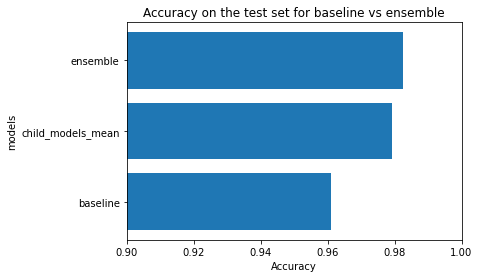

In [12]:
import matplotlib.pyplot as plt
models = ['baseline', 'child_models_mean', 'ensemble']
accuracies = [baseline_val_accuracy]
accuracies_children = []

for ensemble_child_model in ensembled_model.layers[1:6]:
    ensemble_model_child_results = ensemble_child_model.evaluate(test_dataset.batch(batch_size), return_dict=True)
    accuracies_children.append(ensemble_model_child_results['categorical_accuracy'])

mean_accuracy_children = np.mean(np.array(accuracies_children))
accuracies.append(mean_accuracy_children)

accuracies.append(ensembled_results['categorical_accuracy'])

plt.barh(models,accuracies)
plt.title('Accuracy on the test set for baseline vs ensemble')
plt.ylabel('models')
plt.xlabel('Accuracy')
plt.xlim([0.90, 1.0])
plt.show()